# Rice Yield Prediction: PyTorch Final Model (Best Params)

## Overview
This notebook implements the final **PyTorch Neural Network** using the specific hyperparameters found during optimization. It includes tracking and plotting for both **RMSE** (to minimize) and **R2 Score** (to maximize).

### Configuration
* **n_layers:** 2
* **units:** 96
* **dropout:** 0.066
* **learning_rate:** 0.000282
* **batch_size:** 16

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# PyTorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using device: cpu


### 1. Data Preparation

In [2]:
# Load dataset
df = pd.read_parquet('Parquet/XY_version1.parquet')

# Define Target
TARGET_COL = 'Y_rice'
df_model = df.dropna(subset=[TARGET_COL])

# Feature Selection
feature_cols = [c for c in df_model.columns if not c.startswith('Y_') and c not in ['year', 'area']]

# --- TIME-SERIES SPLIT ---
TRAIN_END_YEAR = 2016
VAL_END_YEAR = 2020

# Create Masks
mask_train = df_model['year'] < TRAIN_END_YEAR
mask_val = (df_model['year'] >= TRAIN_END_YEAR) & (df_model['year'] < VAL_END_YEAR)
mask_test = df_model['year'] >= VAL_END_YEAR

# Split Data
X_train_raw = df_model[mask_train][feature_cols]
y_train_raw = df_model[mask_train][TARGET_COL].values.reshape(-1, 1)

X_val_raw = df_model[mask_val][feature_cols]
y_val_raw = df_model[mask_val][TARGET_COL].values.reshape(-1, 1)

X_test_raw = df_model[mask_test][feature_cols]
y_test_raw = df_model[mask_test][TARGET_COL].values.reshape(-1, 1)

# --- PREPROCESSING ---
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()

# Fit on Train, Transform all
X_train_np = scaler.fit_transform(imputer.fit_transform(X_train_raw))
X_val_np = scaler.transform(imputer.transform(X_val_raw))
X_test_np = scaler.transform(imputer.transform(X_test_raw))

# Convert to Tensors
def to_tensor(X, y, device):
    X_t = torch.tensor(X, dtype=torch.float32).to(device)
    y_t = torch.tensor(y, dtype=torch.float32).to(device)
    return X_t, y_t

X_train_t, y_train_t = to_tensor(X_train_np, y_train_raw, device)
X_val_t, y_val_t = to_tensor(X_val_np, y_val_raw, device)
X_test_t, y_test_t = to_tensor(X_test_np, y_test_raw, device)

### 2. Model & Improved Training Loop (RMSE + R2)
We define the model and a specific training loop that calculates R2 at the end of every epoch.

In [3]:
class RiceYieldModel(nn.Module):
    def __init__(self, input_dim, n_layers, units, dropout):
        super(RiceYieldModel, self).__init__()
        layers = []
        
        in_dim = input_dim
        for _ in range(n_layers):
            layers.append(nn.Linear(in_dim, units))
            layers.append(nn.ReLU())
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            in_dim = units
            
        layers.append(nn.Linear(in_dim, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

def train_with_metrics(model, train_loader, X_val, y_val, epochs, lr, patience):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # History tracking
    history = {
        'train_rmse': [], 
        'val_rmse': [],
        'val_r2': []
    }
    
    best_val_loss = float('inf')
    patience_counter = 0
    best_weights = None
    
    print(f"Starting training on {device}...")
    
    for epoch in range(epochs):
        # --- Training Phase ---
        model.train()
        batch_losses = []
        
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
            
        avg_train_rmse = np.sqrt(np.mean(batch_losses))
        
        # --- Validation Phase ---
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_mse = criterion(val_outputs, y_val).item()
            val_rmse = np.sqrt(val_mse)
            
            # Calculate R2 on CPU numpy arrays
            val_r2 = r2_score(y_val.cpu().numpy(), val_outputs.cpu().numpy())
            
        # Store metrics
        history['train_rmse'].append(avg_train_rmse)
        history['val_rmse'].append(val_rmse)
        history['val_r2'].append(val_r2)
        
        # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] | Train RMSE: {avg_train_rmse:.2f} | Val RMSE: {val_rmse:.2f} | Val R2: {val_r2:.4f}")
        
        # Early Stopping (Minimize Validation MSE/RMSE)
        if val_mse < best_val_loss:
            best_val_loss = val_mse
            best_weights = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break
            
    # Load best model
    if best_weights:
        model.load_state_dict(best_weights)
        
    return history

### 3. Apply Best Parameters & Train

In [4]:
# --- CONFIGURATION ---
best_params = {
    'n_layers': 2, 
    'units': 96, 
    'dropout': 0.06606915308411143, 
    'learning_rate': 0.00028216490278536464, 
    'batch_size': 16
}

# 1. Setup DataLoader with specific batch size
train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)

# 2. Initialize Model
model = RiceYieldModel(
    input_dim=X_train_t.shape[1],
    n_layers=best_params['n_layers'],
    units=best_params['units'],
    dropout=best_params['dropout']
).to(device)

# 3. Run Training
history = train_with_metrics(
    model, 
    train_loader, 
    X_val_t, 
    y_val_t, 
    epochs=200, # Generous epoch count, let early stopping handle it
    lr=best_params['learning_rate'], 
    patience=20
)

Starting training on cpu...
Epoch [10/200] | Train RMSE: 1225.80 | Val RMSE: 1410.32 | Val R2: 0.5826
Epoch [20/200] | Train RMSE: 853.23 | Val RMSE: 977.45 | Val R2: 0.7995
Epoch [30/200] | Train RMSE: 728.13 | Val RMSE: 896.01 | Val R2: 0.8315
Epoch [40/200] | Train RMSE: 668.88 | Val RMSE: 814.47 | Val R2: 0.8608
Epoch [50/200] | Train RMSE: 630.07 | Val RMSE: 775.34 | Val R2: 0.8739
Epoch [60/200] | Train RMSE: 593.15 | Val RMSE: 748.94 | Val R2: 0.8823
Epoch [70/200] | Train RMSE: 581.16 | Val RMSE: 721.94 | Val R2: 0.8906
Epoch [80/200] | Train RMSE: 578.56 | Val RMSE: 718.71 | Val R2: 0.8916
Epoch [90/200] | Train RMSE: 566.33 | Val RMSE: 722.34 | Val R2: 0.8905
Epoch [100/200] | Train RMSE: 556.47 | Val RMSE: 727.80 | Val R2: 0.8889
Epoch [110/200] | Train RMSE: 553.69 | Val RMSE: 698.97 | Val R2: 0.8975
Epoch [120/200] | Train RMSE: 550.30 | Val RMSE: 693.47 | Val R2: 0.8991
Epoch [130/200] | Train RMSE: 549.81 | Val RMSE: 701.06 | Val R2: 0.8969
Epoch [140/200] | Train RMSE: 

### 4. Visualization (RMSE & R2)

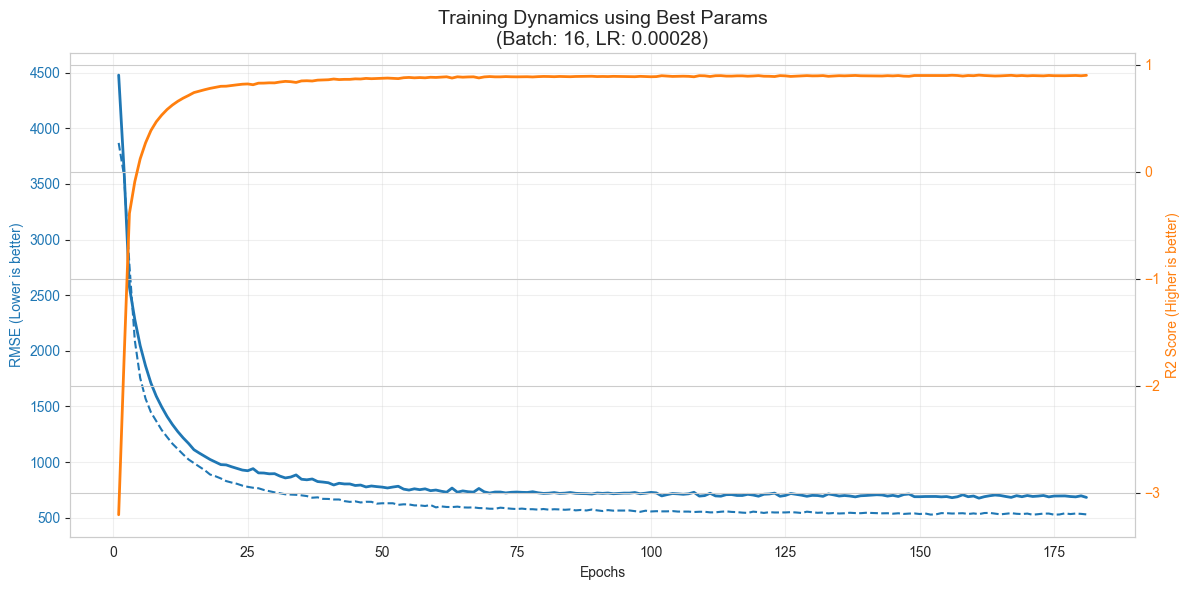

Final Test Set Performance
RMSE: 1082.1136
R2:   0.7623


In [5]:
# Create dual-axis plot or subplots to visualize RMSE and R2 together
fig, ax1 = plt.subplots(figsize=(12, 6))

epochs = range(1, len(history['train_rmse']) + 1)

# Plot RMSE (Left Axis)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('RMSE (Lower is better)', color='tab:blue')
ax1.plot(epochs, history['train_rmse'], label='Train RMSE', color='tab:blue', linestyle='--')
ax1.plot(epochs, history['val_rmse'], label='Val RMSE', color='tab:blue', linewidth=2)
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True, alpha=0.3)

# Plot R2 (Right Axis)
ax2 = ax1.twinx()
ax2.set_ylabel('R2 Score (Higher is better)', color='tab:orange')
ax2.plot(epochs, history['val_r2'], label='Val R2', color='tab:orange', linewidth=2)
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Title & Layout
plt.title(f"Training Dynamics using Best Params\n(Batch: {best_params['batch_size']}, LR: {best_params['learning_rate']:.5f})", fontsize=14)
fig.tight_layout()
plt.show()

# --- FINAL EVALUATION ON TEST SET ---
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_t).cpu().numpy()

test_rmse = np.sqrt(mean_squared_error(y_test_raw, y_pred_test))
test_r2 = r2_score(y_test_raw, y_pred_test)

print("="*40)
print(f"Final Test Set Performance")
print("="*40)
print(f"RMSE: {test_rmse:.4f}")
print(f"R2:   {test_r2:.4f}")